###  Islands: Generalized Linear Models - Chapter 5

[Back to Main Page](0_main_page.ipynb)

<br>

<h1> <center> Multinomial Logistic Regression </center> </h1>  

<br>
<center><img src = "images/island_mul_log_reg.png" width = 270></center>

Imagine you visting a new island, where you and a team of researchers are conducting social research about the three different religions that are practiced there. Your team is interested in the relationship between the following variables:

`income`: a continuous numerical variable, indicating the annual income, in 1000s, of each participant

`religion`: a nominal categorical variable, indicating group membership to one of three religions: `Communionists`, `Symmetrians` or `Lamothians`

`biological_sex`: a binary nominal-categorical variable, indicating the the biological sex of each participant

The data from a random sample of islanders is shown below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.mplot3d import axes3d
import islands_GLM

islands_GLM.r_ify()

# generate the data for this page
df = islands_GLM.data_gen_multinomial()

# show the data
df

C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


,income,religion,biological_sex
0,106,Communionists,female
1,12,Symmetrians,female
2,300,Lamothians,female
3,65,Lamothians,male
4,205,Lamothians,female
...,...,...,...
95,107,Symmetrians,female
96,106,Communionists,male
97,44,Communionists,male
98,74,Lamothians,female


In [2]:
# generate dummy variables
df['religion_dummy'] =  df['religion'].replace(df['religion'].unique(), np.arange(len(df['religion'].unique())))
df['biological_sex_dummy'] =  df['biological_sex'].replace(df['biological_sex'].unique(), np.arange(len(df['biological_sex'].unique())))

# show the data
df

,income,religion,biological_sex,religion_dummy,biological_sex_dummy
0,106,Communionists,female,0,0
1,12,Symmetrians,female,1,0
2,300,Lamothians,female,2,0
3,65,Lamothians,male,2,1
4,205,Lamothians,female,2,0
...,...,...,...,...,...
95,107,Symmetrians,female,1,0
96,106,Communionists,male,0,1
97,44,Communionists,male,0,1
98,74,Lamothians,female,2,0


## Context

We use multinomial logistic regression when we are predicting a categorical variable with several categories.  As with all generalized linear models, the predictor variables can be of any type (quantitative-continuous, quantitative-discrete, nominal-categorical, ordinal-categorical).

Multinomial logistic regression fits a logistic curve for each outcome category, where each curve shows the predicted probability of an observation falling into that category, given the a set of predictor scores. The image below shows 


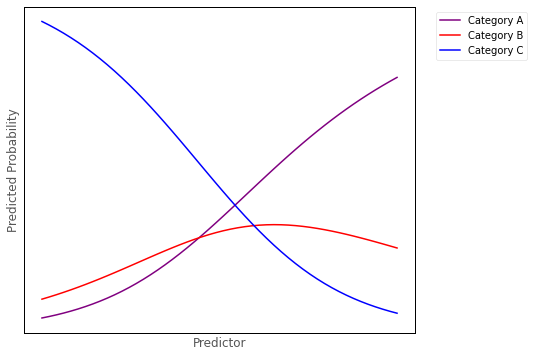

In [3]:
islands_GLM.multinomial_illustration()

Let's assume the graph shows the probability of being in the outcome category dummy coded as 1, as the value of the predictor increases. 

For any value of the predictor, we can use the predicted probability of being in outcome category 1 to calculate the predicted probability of being in outcome category 0. We do this by subtracting the predicted probability of being in outcome category 1, from 1.

We could then, for any value of the predictor, create a barplot of the predicted proportion of scores in either category, for a given value of the predictor. Around the middle of the S shaped curve just shown above, such a barplot might look like:

![](images/multi_log_reg_bar.png)

This is how binary logistic regression works from a 'conditional distribution' perspective: it fits a binomial distribution for every value of the predictor:

![](images/multi_log_reg_conditional.png)

## Model

[Interested in the probability of events in various categories]

$ \large \hat{P}_{(y_{i} = 0)} = \hat\pi_{0i}$ 

$ \large \hat{P}_{(y_{i} = 1)} = \hat\pi_{1i} $

$ \dots $

$ \large \hat{P}_{(y_{i} = ref)} = \hat\pi_{\text{(r)}i} $
[Show whole prediction equation]

$ \Large \hat{y}_{i} = ln\left(\frac{Pr(Y=j)}{Pr(Y=\text{Reference})}\right)_{i} = b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki}  $

$ \large \hat{y}_{i} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_i = b_{0} + b_{i}x_{11} \dots + b_{k}x_{ki} $

The individual prediction ($\hat{y_i}$), for all $n$ observations, using $k$ variables as predictors are:

$$ \large \hat{y}_{1} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_1 = b_{0} + b_{1}x_{11} \dots + b_{k}x_{k1} $$

$$ \large \hat{y}_{2} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_2 = b_{0} + b_{1}x_{12} \dots + b_{k}x_{k2} $$

$$ \large \hat{y}_{3} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_3 = b_{0} + b_{1}x_{13} \dots + b_{k}x_{k3} $$

$$ \dots $$

$$ \large \hat{y}_{n} = ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_n = b_{0} + b_{1}x_{1n} \dots + b_{k}x_{kn} $$

[explanation of above formulas, element by element here]

$$
\Large \begin{bmatrix}
           {\hat{y}_{1}} \\
           {\hat{y}_{2}} \\
           {\hat{y}_{3}} \\
           \vdots \\
           {\hat{y}_{n}}
         \end{bmatrix} = \begin{bmatrix}
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_1 } \\
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_2 } \\
           {ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_3 }  \\
           \vdots \\
           {\ln \left( \frac{\hat\pi_{1}}{\hat\pi_{\text{(r)}i}} \right)_n}
         \end{bmatrix} = \begin{bmatrix}
           {1} & {x_{11}} & \dots & {x_{k1}}\\ 
           {1} & {x_{12}} & \dots & {x_{k2}}\\ 
           {1} & {x_{13}} & \dots & {x_{k3}}\\ 
           \vdots & \vdots & \vdots & \vdots\\
           {1} & {x_{1n}} & \dots & {x_{kn}} \\ 
         \end{bmatrix} \begin{bmatrix}
           {b_{0}} \\ 
           \vdots \\
           {b_{k}} \\ 
         \end{bmatrix} 
$$


## Parameter estimates

The coefficients ($b_0, b_k$) can be estimated by...

For a single score:

[single score value here]

[illustration of different types of normal distribution here]

The predicted probability of falling into class $j$ for observation $i$:

$ \large \hat\pi_{ji} = \frac{e^{\hat{y_ji}}}{1 + e^{\hat{y_{1}}} + ... e^{\hat{y_{ji}}}}  = \frac{e^{\hat{y_ji}}}{1 + \sum{e^{\hat{y_{ji}}}}} $

For the reference category:

$ \large \hat\pi_{\text{(r)}i} = \frac{1}{1 + \sum{e^{\hat{y_{ji}}}}} = 1 - \sum \hat\pi_{ji} $

The model gets its parameters, by maximizing:

$ \large {\operatorname{arg max}} \prod \hat\pi_{0i}^{\text{indicator}_{0i}} \hat\pi_{1i}^{\text{indicator}_{1i}} ...\hat\pi_{ji}^{\text{indicator}_{ji}} $

[illustration of fitting several normal distribution around the regression line here]


Equivalently, by minimizing (has the same effect, but easier for a computer to work with):

[full log like here (with all j), show that because of dummies it reduces to:]

$ \large {\operatorname{arg min}} - \sum \text{indicator}_{ji} * \large[ \hat{y_{ji}}  - \ln(1 + \sum{e^{\hat{y_{ji}}}} )\large]$

[Explain how this works at the level of individual predictions]

## Implementation

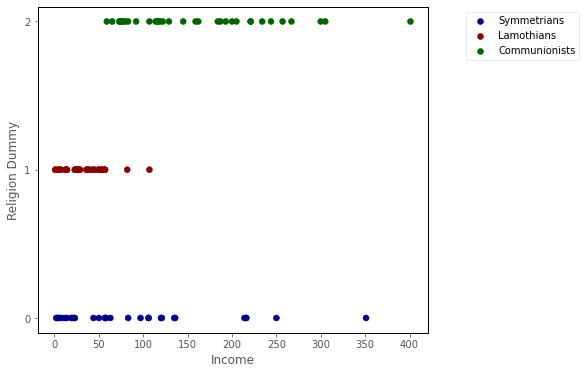

In [4]:
islands_GLM.relig_scatter(df)

In [5]:
def mnlogit_cost(intercept_and_slope, x, y):

    intercept_1, slope_1, intercept_2, slope_2, = intercept_and_slope
    
    predicted_log_odds_1 = intercept_1 + slope_1 * x
    predicted_log_odds_2 = intercept_2 + slope_2 * x

    y_dummies = pd.get_dummies(y)
     
    log_likelihood = np.sum(y_dummies[1].values * predicted_log_odds_1 + y_dummies[2].values * predicted_log_odds_2 - np.log(1 + np.exp(predicted_log_odds_1) +  np.exp(predicted_log_odds_2)))

    return -log_likelihood

In [6]:
mnlogit_cost([.1,.1,.1,.1], df['income'], df['religion_dummy'])

337.63323390489114

In [7]:
from scipy.optimize import minimize

minimize(mnlogit_cost, [1,1,1,1], args =(df['income'], df['religion_dummy']), tol = 1e-16)

      fun: 83.06736812866575
 hess_inv: array([[ 3.25045604e-02, -1.85553515e-04, -3.20466177e-02,
         5.83529148e-05],
       [-1.85553515e-04,  1.54592729e-05,  1.30525215e-04,
         4.14736057e-06],
       [-3.20466177e-02,  1.30525215e-04,  3.18201695e-02,
        -7.72374296e-05],
       [ 5.83529148e-05,  4.14736057e-06, -7.72374296e-05,
         3.20494618e-06]])
      jac: array([ 9.53674316e-07, -5.72204590e-06,  9.53674316e-07,  1.52587891e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 325
      nit: 19
     njev: 54
   status: 2
  success: False
        x: array([ 1.61732035, -0.02690842, -1.19682291,  0.01107856])

In [8]:
mod = sm.MNLogit(df['religion_dummy'], sm.add_constant(df['income'])).fit()

mod.summary()

Optimization terminated successfully.
         Current function value: 0.830674
         Iterations 7


C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         religion_dummy   No. Observations:                  100
Model:                        MNLogit   Df Residuals:                       96
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.2419
Time:                        15:32:27   Log-Likelihood:                -83.067
converged:                       True   LL-Null:                       -109.58
Covariance Type:            nonrobust   LLR p-value:                 3.066e-12
====================================================================================
religion_dummy=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.6173      0.460      3.519      0.000       0.717       2.518
income              -0.0269      0.008     -3.494      0.000      -0.042      -0.012
------------------------------------------------------------------------------------
religion_dummy=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1968      0.495     -2.420      0.016      -2.166      -0.228
income               0.0111      0.004      2.994      0.003       0.004       0.018
====================================================================================
"""

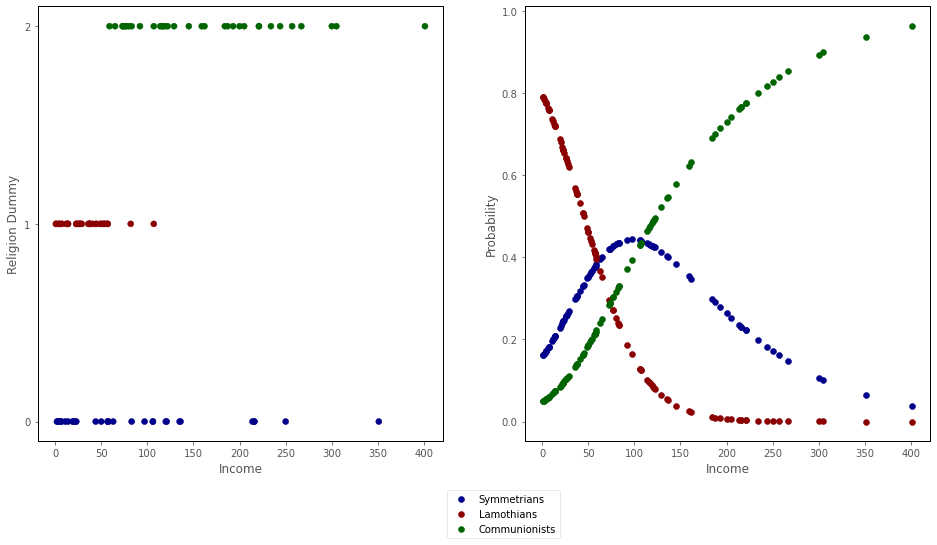

In [9]:
islands_GLM.scatter_prob_subplots(mod, df)

## Multi-predictor multionomial logistic regression

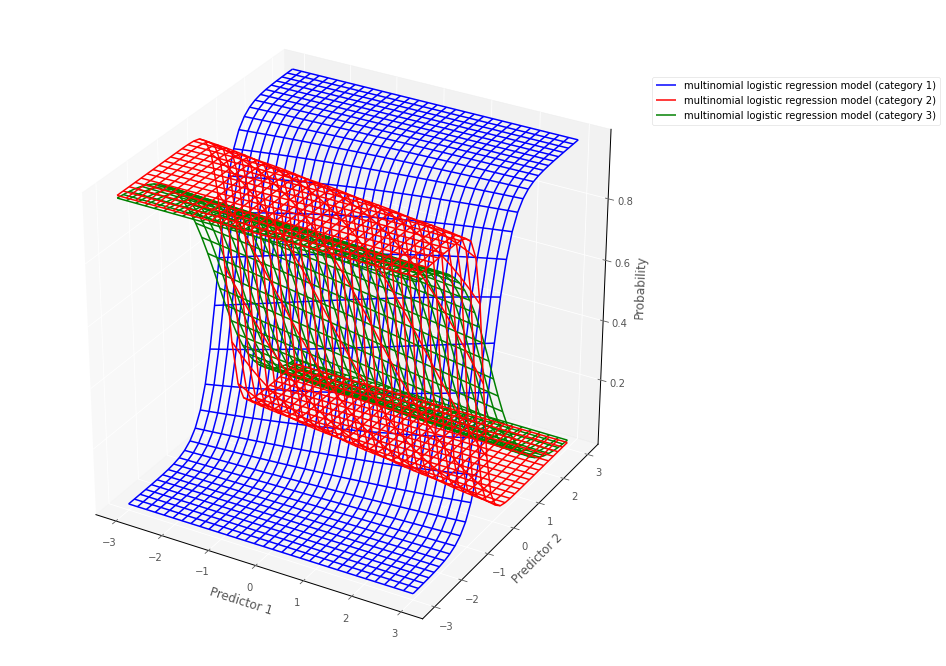

In [10]:
# show how multinomial logistic regression works in multiple dimensions
islands_GLM.multinomial_wireframe()

In [11]:
mod = sm.MNLogit(df['religion_dummy'], sm.add_constant(df[['income', 'biological_sex_dummy']])).fit()

mod.summary()

Optimization terminated successfully.
         Current function value: 0.815796
         Iterations 7


C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         religion_dummy   No. Observations:                  100
Model:                        MNLogit   Df Residuals:                       94
Method:                           MLE   Df Model:                            4
Date:                Tue, 28 Jun 2022   Pseudo R-squ.:                  0.2555
Time:                        15:32:28   Log-Likelihood:                -81.580
converged:                       True   LL-Null:                       -109.58
Covariance Type:            nonrobust   LLR p-value:                 2.008e-11
========================================================================================
    religion_dummy=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.5185      0.780      3.227      0.001       0.989       4.048
income                  -0.0300      0.008     -3.664      0.000      -0.046      -0.014
biological_sex_dummy    -1.0302      0.669     -1.541      0.123      -2.341       0.280
----------------------------------------------------------------------------------------
    religion_dummy=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5367      0.737     -0.728      0.467      -1.982       0.908
income                   0.0089      0.004      2.155      0.031       0.001       0.017
biological_sex_dummy    -0.7422      0.619     -1.198      0.231      -1.956       0.472
========================================================================================
"""

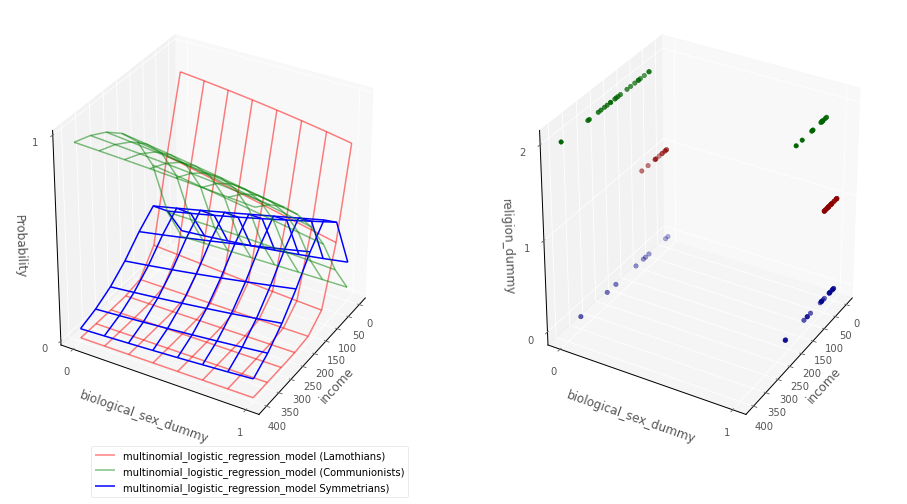

In [12]:
intercept_1, income_slope_1, biological_sex_dummy_slope_1 = mod.params[0][:]
intercept_2, income_slope_2, biological_sex_dummy_slope_2 = mod.params[1][:]
islands_GLM.three_D_model_plot_multinomial('income', 'biological_sex_dummy', 
                   'religion_dummy', intercept_1, income_slope_1, biological_sex_dummy_slope_1, intercept_2, income_slope_2, biological_sex_dummy_slope_2,
                  df, 'multinomial_logistic_regression_model')

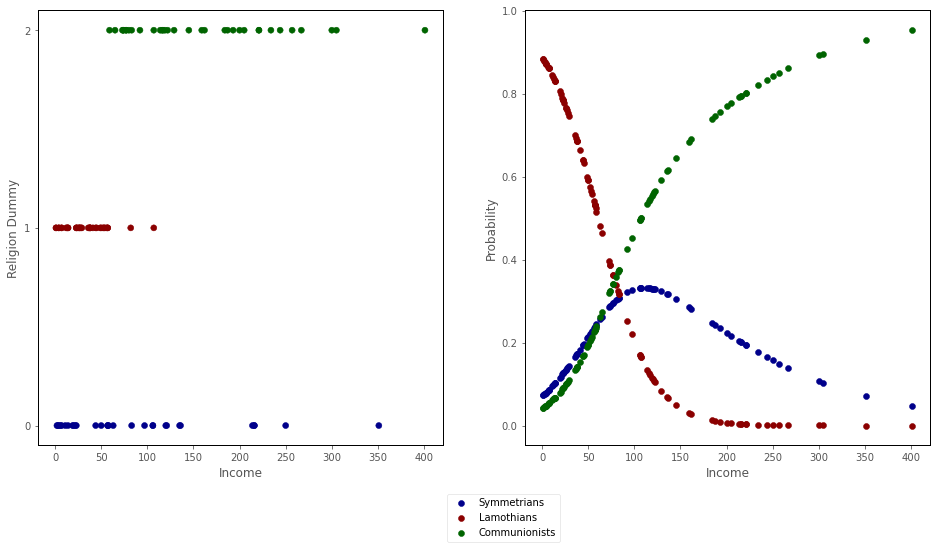

In [13]:
# easier to see pattern on this plot
islands_GLM.scatter_prob_subplots(mod, df)

## Interpretation (multiple predictors)

The coefficient of each predictor tells us the predicted difference in the outcome variable scores for two observations which differed *only* by a one unit score in that predictor. E.g. which had the same score on all other predictors.

The intercept tells us the predicted score on the outcome variable for an observation whose score on all other predictors was 0. 

## Statistical interaction in Multinomial Logistic Regression

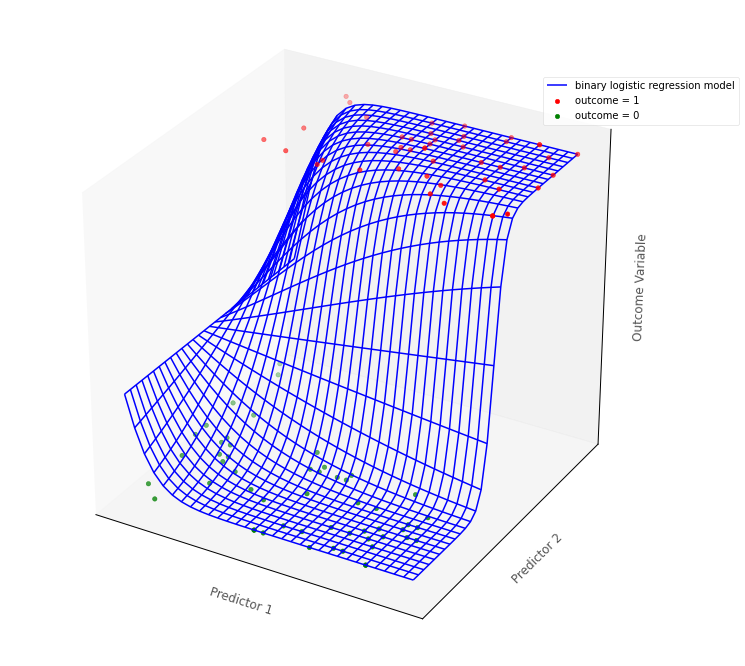

In [14]:
islands_GLM.bin_log_reg_plot(interaction = True)

## Other Chapters

1. [What are Generalized Linear Models?](1_generalized_linear_models.ipynb)
2. [Linear Regression](2_linear_regression.ipynb)
3. [Poisson Regression](3_poisson_regression.ipynb)
4. [Binary Logistic Regression](4_binary_logistic_regression.ipynb)
5. [Multinomial Logistic Regression](5_multinomial_logistic_regression.ipynb)

***
By [pxr687](99_about_the_author.ipynb) 